<a href="https://colab.research.google.com/github/Thiru2208/CM2607_CW/blob/main/2425449_20241152_CM2607_CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from numpy.fft import rfft, rfftfreq
import cv2

Modelling Travel Time

In [5]:
#Define Symbols
x, y = sp.symbols('x y', positive = True, real = True)
a, b, c = sp. symbols ('a  b c', positive = True, real = True)

#Travel time modela
Tb = a*x**2 + b*y**2
Tt = sp.sqrt(c*(x**2 + y**2))

Tb, Tt

(a*x**2 + b*y**2, sqrt(c)*sqrt(x**2 + y**2))

In [8]:
# Compute gradients
dTb_dx = sp.diff(Tb, x)
dTb_dy = sp.diff(Tb, y)
dTt_dx = sp.diff(Tt, x)
dTt_dy = sp.diff(Tt, y)

grad_Tb = (sp.simplify(dTb_dx), sp.simplify(dTb_dy))
grad_Tt = (sp.simplify(dTt_dx), sp.simplify(dTt_dy))

print("Gradient for bus is ",grad_Tb)
print("Gradient for Taxi is ",grad_Tt)

Gradient for bus is  (2*a*x, 2*b*y)
Gradient for Taxi is  (sqrt(c)*x/sqrt(x**2 + y**2), sqrt(c)*y/sqrt(x**2 + y**2))


In [9]:
# ----- Numeric evaluation helper -----
x0 = 4.5  # given route distance (approx)

# Example parameters (CHANGE these to your chosen assumptions later)
a0 = 2.0
b0 = 1.0
c0 = 9.0

# Choose a few traffic delay values (min/km)
y_values = [1, 3, 6]

# Substitute and evaluate partial derivatives at (x0, y)
for y0 in y_values:
    bus_dx = float(dTb_dx.subs({a:a0, x:x0}))
    bus_dy = float(dTb_dy.subs({b:b0, y:y0}))

    taxi_dx = float(dTt_dx.subs({c:c0, x:x0, y:y0}))
    taxi_dy = float(dTt_dy.subs({c:c0, x:x0, y:y0}))

    print(f"\nAt x={x0} km, y={y0} min/km")
    print(f"Bus:  ∂Tb/∂x = {bus_dx:.3f},  ∂Tb/∂y = {bus_dy:.3f}")
    print(f"Taxi: ∂Tt/∂x = {taxi_dx:.3f},  ∂Tt/∂y = {taxi_dy:.3f}")



At x=4.5 km, y=1 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 2.000
Taxi: ∂Tt/∂x = 2.929,  ∂Tt/∂y = 0.651

At x=4.5 km, y=3 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 6.000
Taxi: ∂Tt/∂x = 2.496,  ∂Tt/∂y = 1.664

At x=4.5 km, y=6 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 12.000
Taxi: ∂Tt/∂x = 1.800,  ∂Tt/∂y = 2.400


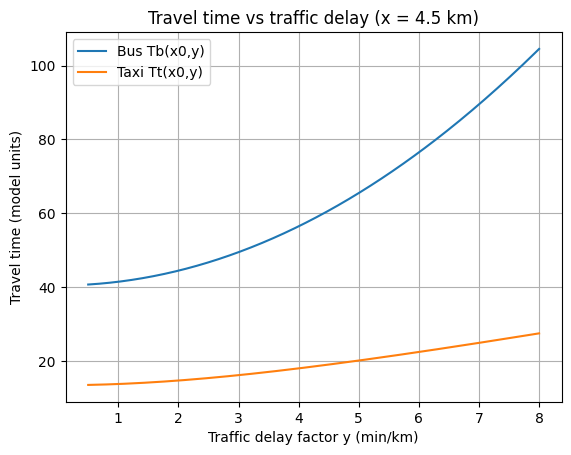

In [10]:
ys = np.linspace(0.5, 8.0, 250)

Tb_num = a0*(x0**2) + b0*(ys**2)
Tt_num = np.sqrt(c0*((x0**2) + (ys**2)))

plt.figure()
plt.plot(ys, Tb_num, label="Bus Tb(x0,y)")
plt.plot(ys, Tt_num, label="Taxi Tt(x0,y)")
plt.xlabel("Traffic delay factor y (min/km)")
plt.ylabel("Travel time (model units)")
plt.title("Travel time vs traffic delay (x = 4.5 km)")
plt.grid(True)
plt.legend()
plt.show()
